In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json

In [3]:
############################################
sweep_root = "../../results/faithfulness_baselines"
model_name = "gptj"
############################################

results_file = f"{sweep_root}/{model_name}.json"
fig_dir = "figs"


os.makedirs(fig_dir, exist_ok=True)

with open(results_file, "r") as f:
    results_raw = json.load(f)

In [4]:
def format_results(results_raw):
    results_formatted = {}
    for relation_results in results_raw:
        result = {k: v for k, v in relation_results.items() if k != "trials"}
        result["recall"] = {}
        for trial_result in relation_results["trials"]:
            prompting_approaches = ["zero_shot", "icl"]
            for approach in prompting_approaches:
                if approach not in result["recall"]:
                    result["recall"][approach] = {}
                for method_key in trial_result[approach]:
                    if method_key not in result["recall"][approach]:
                        result["recall"][approach][method_key] = []
                    result["recall"][approach][method_key].append(trial_result[approach][method_key]["recall"])
        
        for approach in prompting_approaches:
            for method_key in result["recall"][approach]:
                result["recall"][approach][method_key] = np.array(result["recall"][approach][method_key]).mean(axis = 0)
        
        results_formatted[relation_results["relation_name"]] = result

    return results_formatted

results_formatted = format_results(results_raw)

In [5]:
dataset = data.load_dataset()
relations_by_name = {r.name: r for r in dataset.relations}

In [6]:
from typing import Literal

def segregate_categorywise(
    results_formatted: dict,
    property_key: Literal["relation_type", "fn_type", "disambiguating", "symmetric"] = "relation_type"
) -> dict:
    performance_category_wise = {}
    for relation_name in results_formatted:
        property_value = relations_by_name[relation_name].properties.__dict__[property_key]
        result = results_formatted[relation_name]
        if property_value not in performance_category_wise:
            performance_category_wise[property_value] = {}
        for prompting in result["recall"]:
            if prompting not in performance_category_wise[property_value]:
                performance_category_wise[property_value][prompting] = {}

            for method in result["recall"][prompting]:
                if method not in performance_category_wise[property_value][prompting]:
                    performance_category_wise[property_value][prompting][method] = []
                performance_category_wise[property_value][prompting][method].append(result["recall"][prompting][method])
        

    for property_value in performance_category_wise:
        for prompting in performance_category_wise[property_value]:
            for method in performance_category_wise[property_value][prompting]:
                performance_category_wise[property_value][prompting][method] = np.array(performance_category_wise[property_value][prompting][method]).mean(axis = 0)
    
    return performance_category_wise

In [7]:
performance_category_wise = segregate_categorywise(results_formatted, "relation_type")

In [8]:
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 28
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################


def plot_categorywise(canvas, result, title, set_yticks = True):
    bar_width = 0.4
    prompting_colors = {"zero_shot": "deepskyblue", "icl": "darkblue"}
    method_name_dict  = {
        "logit_lens": "Logit Lens",
        "corner": "Offshoot",
        "learned_linear": "Linear Regression",
        "lre_emb": "LRE (emb)",
        "lre": "LRE"
    }
    idx = 0
    for prompting in result:
        recalls = [result[prompting][method][0] for method in result[prompting]]
        canvas.barh(
            np.arange(len(recalls)) + idx * bar_width, recalls, 
            height = bar_width, label = prompting.capitalize(), 
            color = prompting_colors[prompting],
            edgecolor = "black",
            alpha = 0.8
        )
        idx += 1
    
    canvas.set_xlim(0, 1)
    canvas.set_title(title.capitalize())

    if set_yticks:
        canvas.set_yticks(np.arange(len(result[prompting])) + 0.5 * bar_width)
        canvas.set_yticklabels([method_name_dict[method] for method in result[prompting]])
    else:
        canvas.set_yticks(np.arange(len(result[prompting])) + 0.5 * bar_width)
        canvas.set_yticklabels(["" for method in result[prompting]])
        

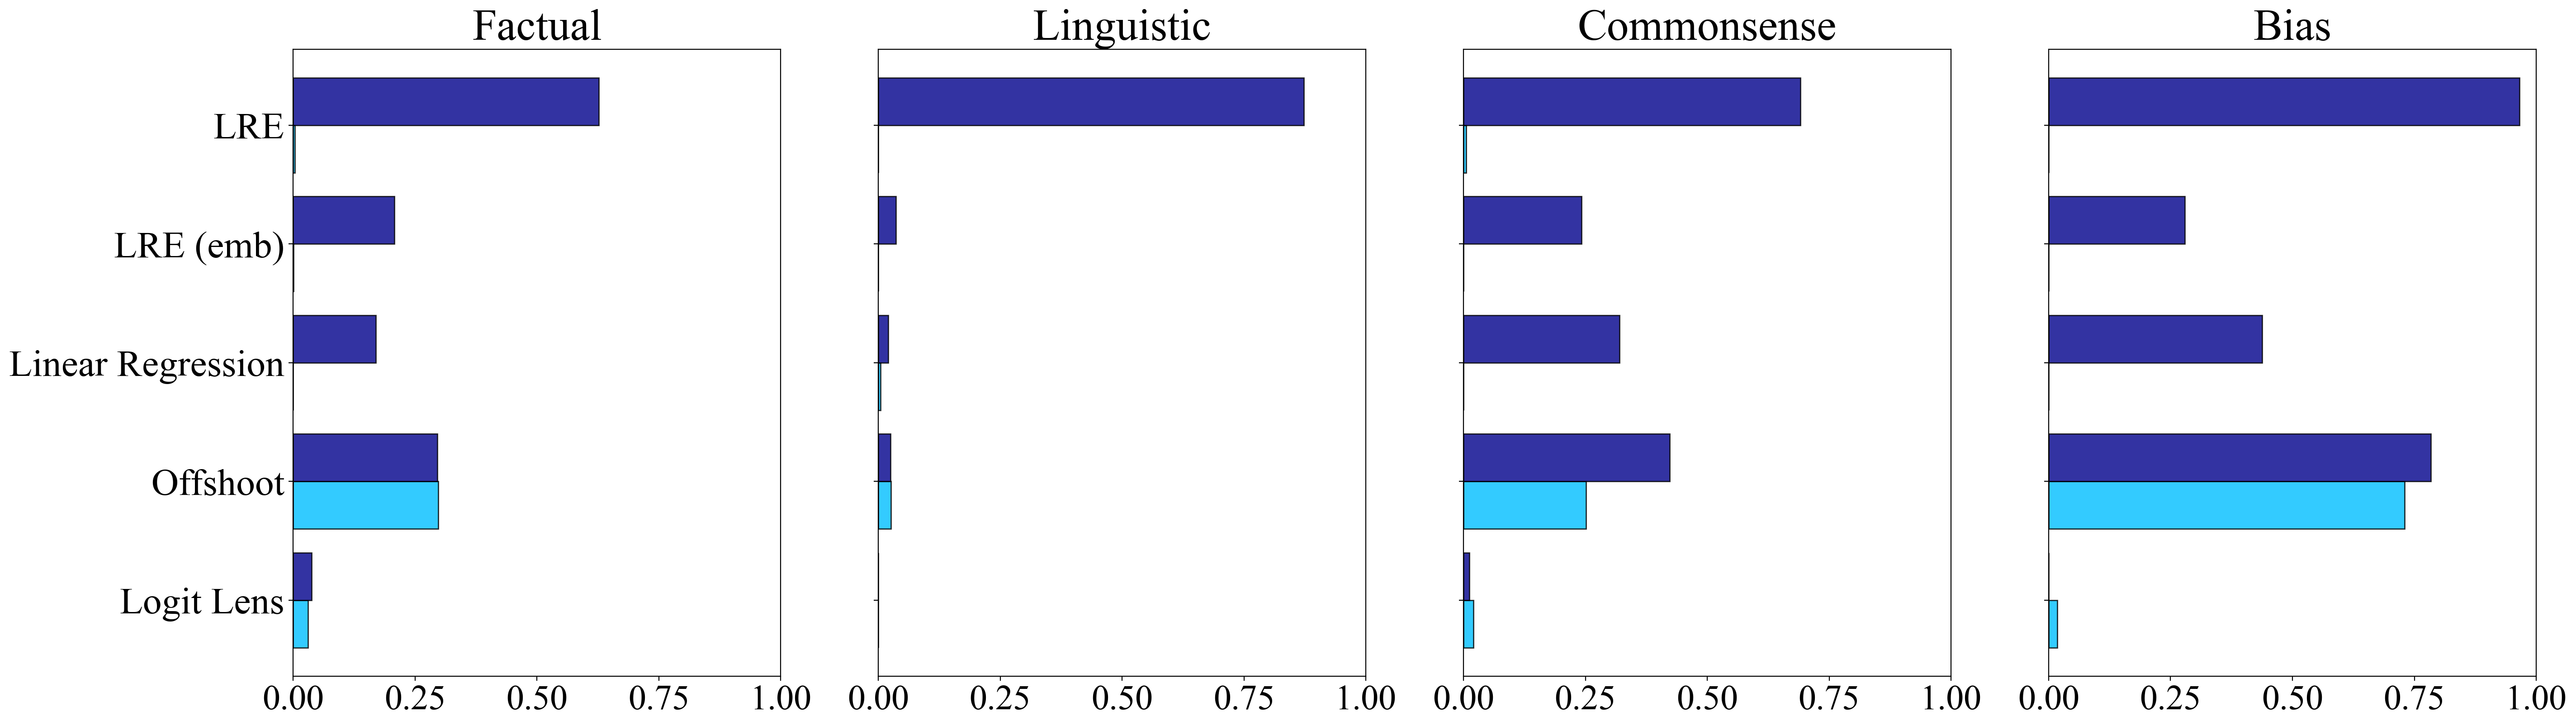

In [9]:
n_subplots = len(performance_category_wise)
ncols=4
nrows=int(np.ceil(n_subplots / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 9))
if nrows == 1:
    axes = [axes]
if ncols == 1:
    axes = [[ax] for ax in axes]

ax_col, ax_row = 0, 0
for i, (category, result) in enumerate(performance_category_wise.items()):
    plot_categorywise(canvas = axes[ax_row][ax_col], result = result, title = category, set_yticks = ax_col == 0)
    ax_col += 1
    if ax_col == ncols:
        ax_col = 0
        ax_row += 1
    # break

plt.savefig(f"{fig_dir}/faithfulness_lre_methods.pdf", bbox_inches="tight")
fig.show()

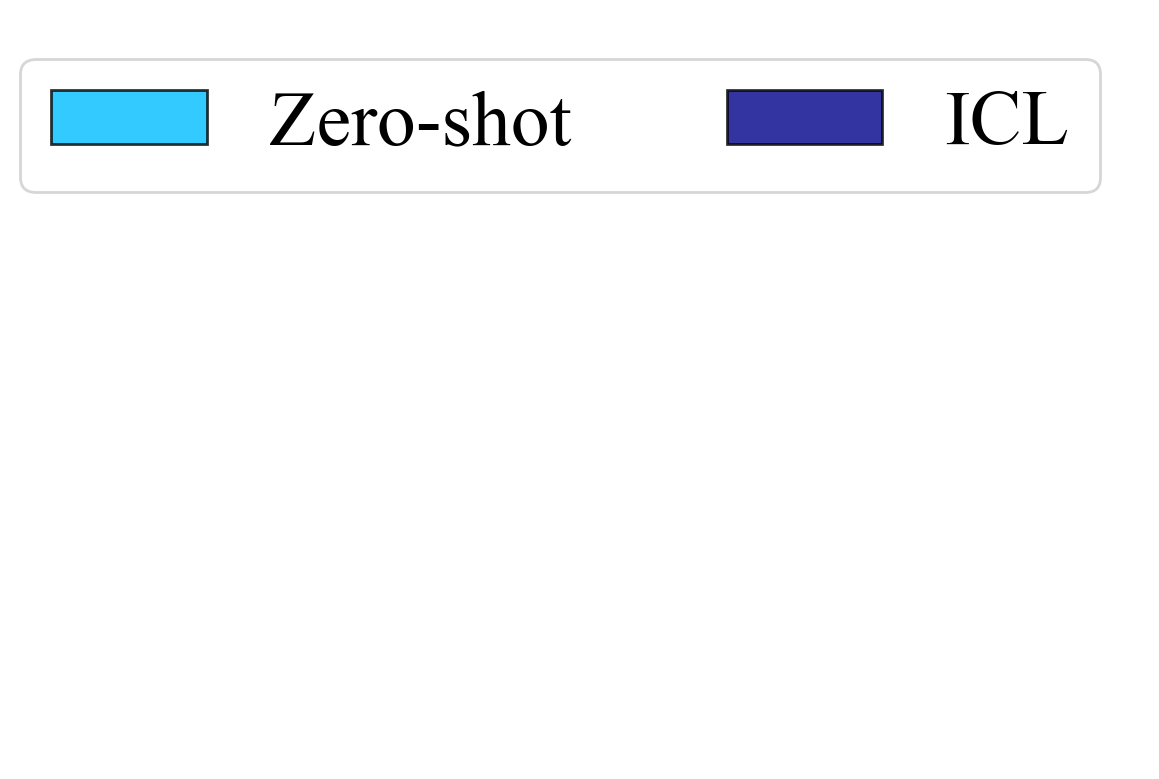

In [10]:
import matplotlib as mpl
palette = dict(zip(['Zero-shot', "ICL"], ['deepskyblue', 'darkblue']))
handles = [mpl.patches.Patch(facecolor=palette[x], label=x, edgecolor="black", alpha=0.8) for x in palette.keys()]
# Create legend
plt.legend(handles=handles, ncols=2)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.savefig(f"{fig_dir}/legend_faithfulness_lre.pdf", format="pdf", bbox_inches="tight")

In [11]:
MODELS = ["gpt2-xl", "gptj", "llama"]
categorywise_results = {}

for model_name in MODELS:
    results_file = f"{sweep_root}/{model_name}.json"
    with open(results_file, "r") as f:
        results_raw = json.load(f)
    results_formatted = format_results(results_raw)

    category_wise = segregate_categorywise(results_formatted, "relation_type")
    for category in category_wise:
        category_wise[category] = category_wise[category]['icl']["lre"][0]
    
    for category in category_wise:
        if category not in categorywise_results:
            categorywise_results[category] = {}
        categorywise_results[category][model_name] = category_wise[category]

categorywise_results

{'linguistic': {'gpt2-xl': 0.7917368023086391,
  'gptj': 0.8725808276045763,
  'llama': 0.8505838396643256},
 'bias': {'gpt2-xl': 0.8067866161616161,
  'gptj': 0.9657169990503323,
  'llama': 0.8290841977816769},
 'factual': {'gpt2-xl': 0.6233057596115817,
  'gptj': 0.6269611847194515,
  'llama': 0.5384361573096964},
 'commonsense': {'gpt2-xl': 0.6295921603892617,
  'gptj': 0.6909379229728067,
  'llama': 0.6846752153750442}}

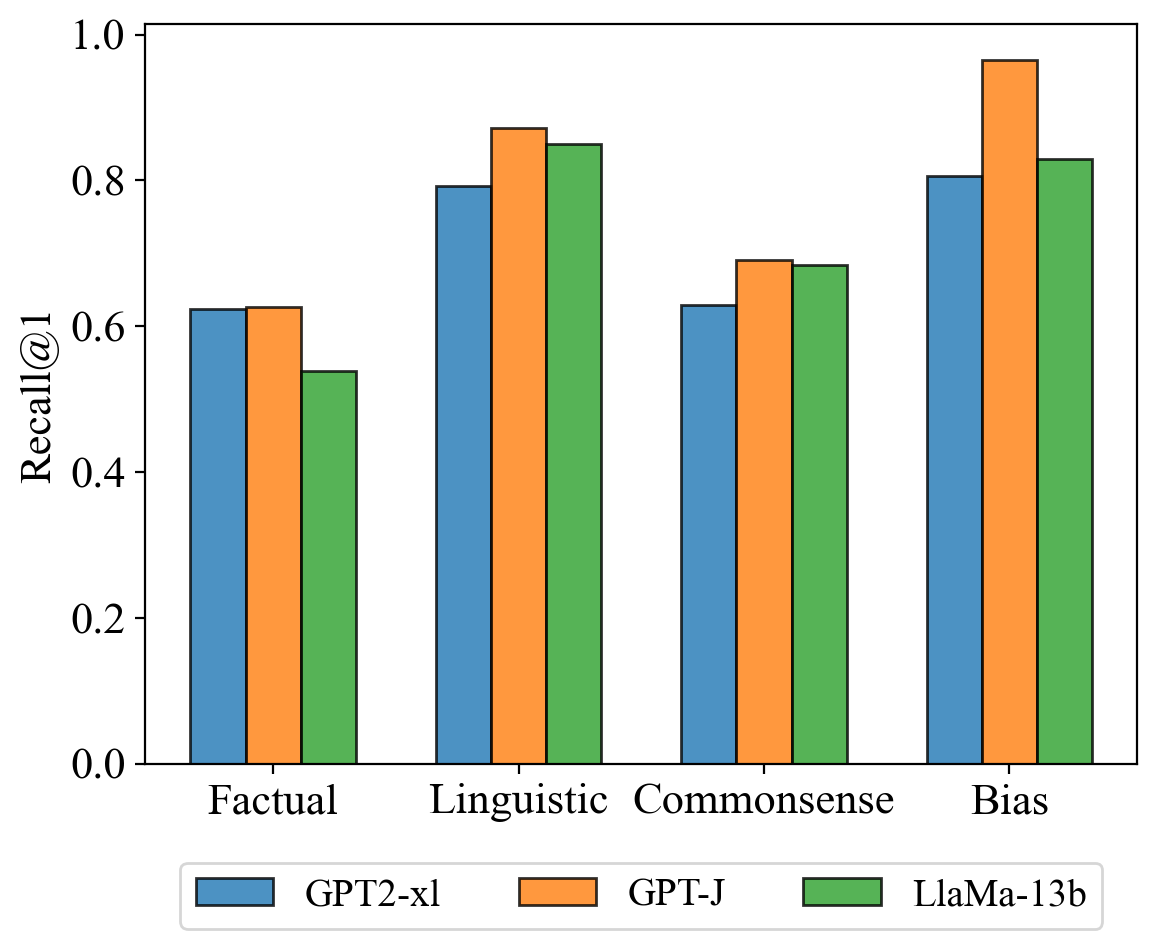

In [12]:
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################


n_subplots = len(categorywise_results)
ncols=n_subplots
nrows=int(np.ceil(n_subplots / ncols))

category_order = ["factual", "linguistic", "commonsense", "bias"]
models = {"gpt2-xl": "GPT2-xl", "gptj": "GPT-J", "llama": "LlaMa-13b"}

idx = 0
bar_width = 0.225
for model in models:
    recalls = []
    for category in category_order:
        recalls.append(categorywise_results[category][model])
    
    plt.bar(
        np.arange(len(recalls)) + idx * bar_width, recalls,
        width = bar_width,
        label = models[model],
        edgecolor = "black",
        alpha = 0.8
    )
    idx += 1

plt.xticks(np.arange(len(recalls)) + bar_width, [cat.capitalize() for cat in category_order])
plt.ylabel("Recall@1")
plt.legend(ncol = 3, bbox_to_anchor=(0.5, -.25), loc='lower center')
plt.savefig(f"{fig_dir}/faithfulness_lre_models.pdf", bbox_inches="tight")
plt.show()

In [13]:
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 28

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

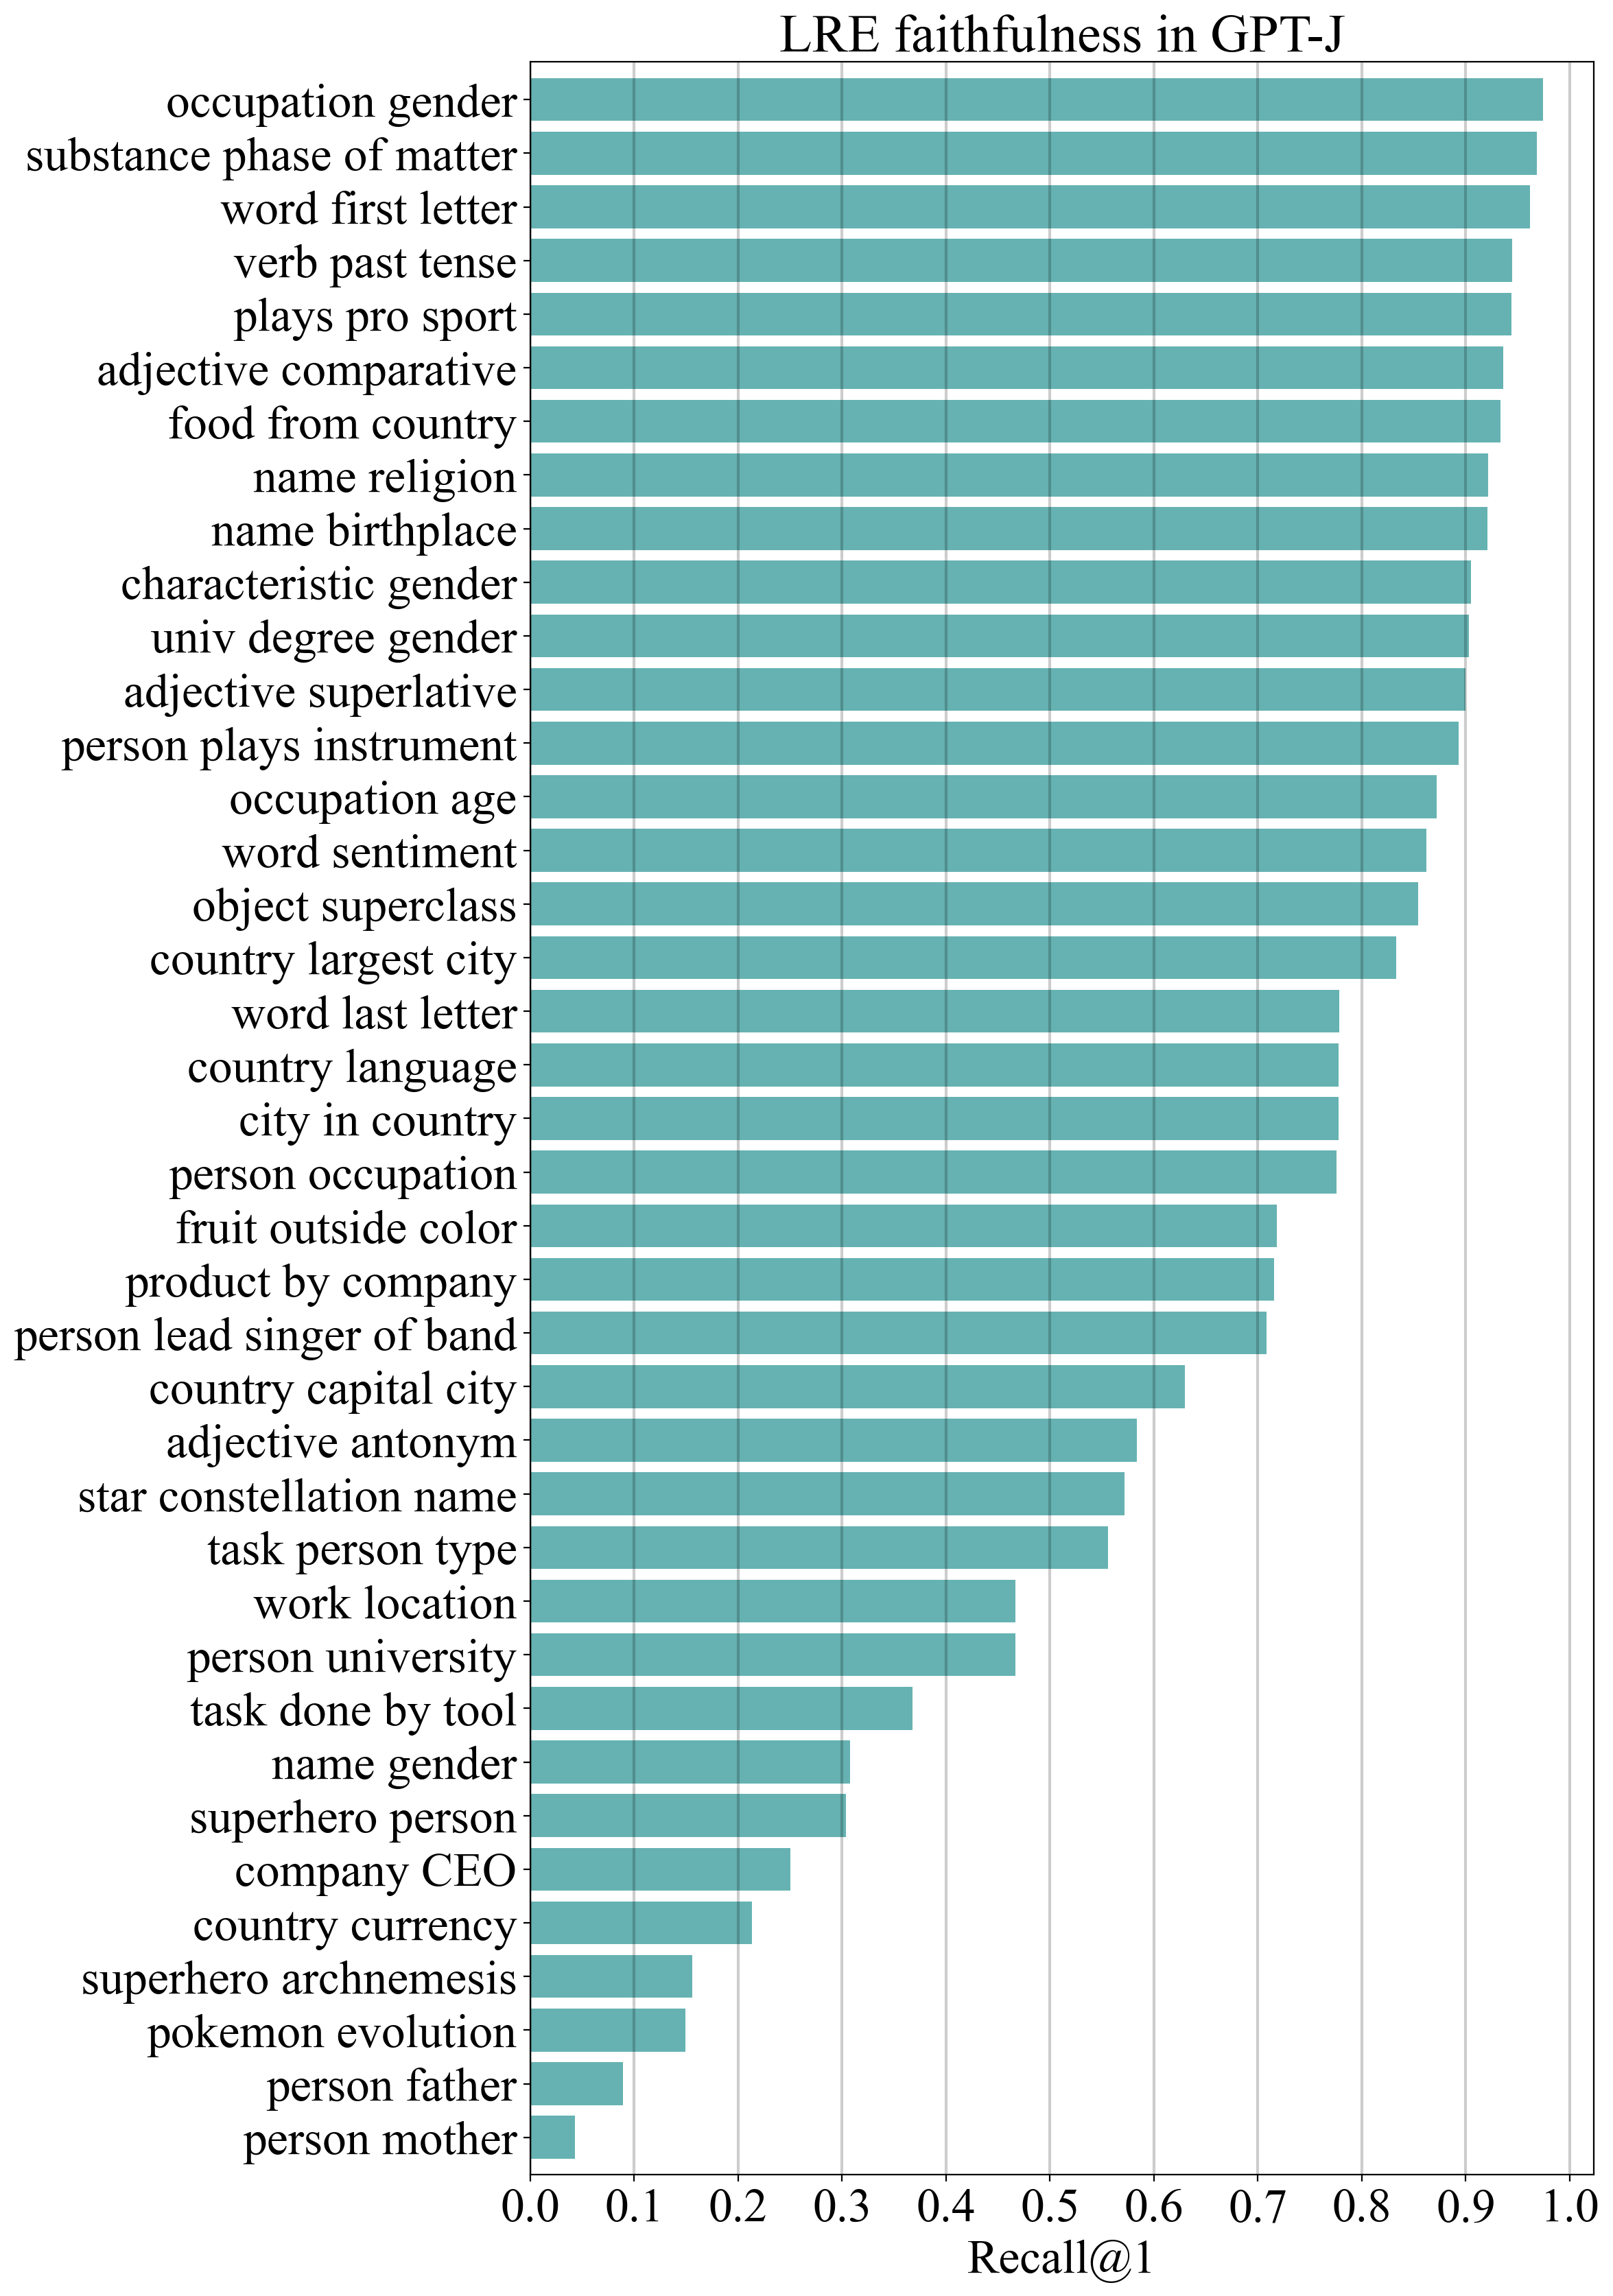

In [14]:
relation_and_recall = []

for relation_name in results_formatted:
    relation_and_recall.append({
        "relation": relation_name,
        "recall@1": results_formatted[relation_name]["recall"]['icl']["lre"][0]
    })

relation_and_recall = sorted(relation_and_recall, key = lambda x: x["recall@1"])

relations = [r["relation"] for r in relation_and_recall]
recalls = [r["recall@1"] for r in relation_and_recall]

plt.figure(figsize = (10, 20))
plt.barh(np.arange(len(relations)), recalls, color = "teal", alpha = 0.6)
plt.yticks(np.arange(len(relations)), relations)
plt.xticks(np.linspace(0, 1, 11), [np.round(v, 1) for v in np.linspace(0, 1, 11)])
plt.ylim(-0.7,len(relation_and_recall)-.3)
plt.xlabel("Recall@1")

for x_tick in np.linspace(0, 1, 11):
    plt.axvline(x_tick, color = "black", alpha = 0.2)

plt.title("LRE faithfulness in GPT-J")
plt.savefig(f"{fig_dir}/faithfulness_lre_relationwise.pdf", bbox_inches="tight")
plt.show()

In [15]:
from src import models

mt = models.load_model("gptj", fp16=True, device="cuda")

In [16]:
models.determine_device(mt)

device(type='cuda', index=0)

In [17]:
mt.tokenizer.eos_token

'<|endoftext|>'

In [18]:
from src import functional
dataset = data.load_dataset()
relations_by_name = {r.name: r for r in dataset.relations}

In [19]:
train, test = relations_by_name["country capital city"].split(size = 5)

In [20]:
print(functional.make_prompt(
    mt = mt,
    prompt_template="The capital of {} is",
    subject = "{}",
    examples=train.samples
))

<|endoftext|>The capital of India is New Delhi
The capital of United States is Washington D.C.
The capital of Egypt is Cairo
The capital of Chile is Santiago
The capital of Peru is Lima
The capital of {} is


In [21]:
print(functional.make_prompt(
    mt = mt,
    prompt_template="{}",
    subject = "{}",
    examples=[]
))

<|endoftext|>
{}


In [22]:
import torch
import baukit
from src.utils import tokenizer_utils


    

def __precompute_hs(
    *,
    mt: models.ModelAndTokenizer,
    prompt_template: str,
    subjects: list[str],
    examples: list[data.RelationSample] | None = None,
    batch_size: int = 16,
    layer_names: list[str]
) -> dict[str, dict[str, torch.Tensor]]:
    """Precompute h for every subject at every layer."""
    prompts = [
        functional.make_prompt(
            mt=mt,
            prompt_template=prompt_template,
            subject=subject,
            examples=examples,
        )
        for subject in subjects
    ]
    device = models.determine_device(mt)
    inputs = mt.tokenizer(
        prompts,
        return_tensors="pt",
        padding="longest",
        return_offsets_mapping=True,
    ).to(device)
    offset_mapping = inputs.pop("offset_mapping")

    hidden_states = []
    for i in range(0, len(inputs.input_ids), batch_size):
        with baukit.TraceDict(
            mt.model, layers = layer_names
        ) as traces:
            outputs = mt.model(
                inputs.input_ids[i : i + batch_size],
                attention_mask=inputs.attention_mask[i : i + batch_size],
            )
        cur_batch_size = functional.untuple(traces[layer_names[0]].output).shape[0]
        for j in range(cur_batch_size):
            hidden_states.append({
                layer_name: functional.untuple(traces[layer_name].output)[j]
                for layer_name in layer_names
            })

    hs_by_subj = {}
    # print(len(hidden_states), len(subjects))
    # for layer_name in layer_names:
    #     print(layer_name, hidden_states[0][layer_name].shape)
    for i, (subject, prompt) in enumerate(zip(subjects, prompts)):
        _, h_index = tokenizer_utils.find_token_range(
            prompt, subject, offset_mapping=offset_mapping[i]
        )
        h_index -= 1
        hs_by_subj[subject] = {
            layer_name: hidden_states[i][layer_name][h_index]
            for layer_name in layer_names
        }

    return hs_by_subj

hs = __precompute_hs(
    mt=mt,
    prompt_template="The capital of {} is",
    subjects=[x.subject for x in test.samples],
    batch_size=8,
    examples=train.samples,
    layer_names = models.determine_layer_paths(mt, layers = ["emb", 27])
)

In [24]:
def get_h(
    mt: models.ModelAndTokenizer,
    prompt_template: str,
    subject: str,
    layer_names: list[str],
) -> dict[str, torch.Tensor]:
    prompt = prompt_template.format(subject)
    device = models.determine_device(mt)

    inputs = mt.tokenizer(
        [prompt],
        return_tensors="pt",
        padding="longest",
        return_offsets_mapping=True,
    ).to(device)

    with baukit.TraceDict(mt.model, layers=layer_names) as traces:
        outputs = mt.model(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
        )
    _, h_index = tokenizer_utils.find_token_range(
        prompt, subject, tokenizer=mt.tokenizer
    )
    h_index -= 1
    return {
        layer_name: functional.untuple(traces[layer_name].output)[0][h_index]
        for layer_name in layer_names
    }

In [27]:
prompt_template = "The capital of {} is"


icl_prompt = functional.make_prompt(
    mt=mt,
    prompt_template=prompt_template,
    examples=train.samples,
    subject="{}",
)

In [29]:
h_icl = get_h(
    mt=mt,
    prompt_template=icl_prompt,
    subject="India",
    layer_names=models.determine_layer_paths(
        mt, ["emb", 15]
    ),
)

h_zs = get_h(
    mt=mt,
    prompt_template=mt.tokenizer.eos_token + "{}",
    subject="India",
    layer_names=models.determine_layer_paths(
        mt, ["emb", 15]
    ),
)

In [30]:
h_icl

{'transformer.wte': tensor([ 0.0169, -0.0025, -0.0030,  ...,  0.0143,  0.0134,  0.0101],
        device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>),
 'transformer.h.15': tensor([-0.2478, -1.3770, -0.2981,  ..., -0.3154,  1.0645,  1.2236],
        device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)}

In [31]:
h_zs

{'transformer.wte': tensor([ 0.0278, -0.0136,  0.0044,  ...,  0.0163,  0.0133,  0.0029],
        device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>),
 'transformer.h.15': tensor([ 0.5830, -1.0947, -0.1572,  ..., -1.0166,  0.0205,  0.0795],
        device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)}

In [33]:
from src.lens import logit_lens

logit_lens(mt, h = h_icl["transformer.h.15"])

([("'s", 15.211),
  (' is', 13.234),
  ('�', 12.836),
  ('-', 12.352),
  (',', 12.023),
  (' has', 11.523),
  (' government', 11.117),
  ('apolis', 10.969),
  (' -', 10.789),
  (' –', 10.742)],
 {})

In [34]:
logit_lens(mt, h = h_zs["transformer.h.15"])

([("'s", 14.289),
  (' government', 11.953),
  ('�', 11.438),
  (' cricket', 11.234),
  (' Government', 11.141),
  (' Gov', 10.734),
  (' Railway', 10.68),
  (' National', 10.531),
  ('apolis', 10.383),
  (' Supreme', 10.32)],
 {})